In [68]:
from opt.mc_sim import *
import time
from common.variables import *

In [85]:
# sourcingEnv = SourcingEnv(
#         lambda_arrival = 8, # or 10
#         procurement_cost_vec = np.array([3, 1, 2]),
#         supplier_lead_times_vec = np.array([0.8, 0.5, 1.0]),
#         on_times = np.array([1, 1, 2]), 
#         off_times = np.array([0.3, 1, 0.2]))

# Dual Sourcing
sourcingEnv = SourcingEnv(
        lambda_arrival = LAMBDA, # or 10
        procurement_cost_vec = np.array([3, 1]),
        supplier_lead_times_vec = np.array([0.8, 0.5]),
        on_times = np.array([1, 1]), 
        off_times = np.array([0.3, 1]))

s_custom = MState(stock_level = 0, 
    n_suppliers = N_SUPPLIERS, 
    n_backorders = np.array([0, 0]), 
    flag_on_off = np.array([1, 1]))

mc_avg_costs = mc_with_ss_policy(sourcingEnv, start_state = s_custom, 
    periods = 500,
    nested_mc_iters = 50,
    big_s = 5,
    small_s = 2,
    h_cost = 2,
    b_penalty = 7)

# print(mc_avg_costs)

In [86]:
print(s_custom)

Stock: 0, n backorders: [0 0], supplier status (on/off): [1 1]


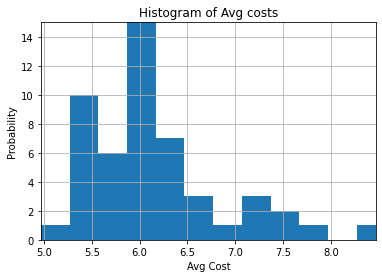

In [87]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 0.3
n, bins, patches = plt.hist(mc_avg_costs, bins=np.arange( np.min(mc_avg_costs), np.max(mc_avg_costs) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs), np.max(mc_avg_costs))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [88]:
print(np.mean(np.array(mc_avg_costs)))

6.144879999999998


In [89]:
np.std(np.array(mc_avg_costs))

0.7044767885459392

In [74]:
print(sourcingEnv.reset())

Stock: 0, n backorders: [0. 0.], supplier status (on/off): [1. 1.]


In [75]:
repr(str(sourcingEnv.reset()))

"'Stock: 0, n backorders: [0. 0.], supplier status (on/off): [1. 1.]'"

In [76]:
import pickle as pkl
from opt.eval_policy import *

# filename = "output/msource_value_dic_06-16-2022-09-56-03.pkl"
filename = "output/msource_value_dic_06-19-2022-23-04-24.pkl"

with open(filename, 'rb') as f:
    output_obj = pkl.load(f)

value_dic = output_obj["state_value_dic"]
model_params = output_obj["model_params"]

In [77]:
model_params

{'algo_params': {'prob_epsilon': 1e-08,
  'periods': 3,
  'nested_mc_iters': 2,
  'mc_episodes': 3,
  'max_steps': 3,
  'explore_eps': 0.05},
 'policy_params': {'h_cost': 2,
  'b_penalty': 7,
  'small_s': 2,
  'big_s': 15,
  'n_suppliers': 2,
  'backorder_max': -10,
  'inven_limit': 30},
 'mdp_env_params': {'lambda': 9,
  'max_inven': 30,
  'action_size': 4,
  'discount_fac': 1.0}}

In [78]:
# try a bit of indifference rounding
# for k in value_dic.keys():
#     value_dic[k] = round(value_dic[k], 3)


In [79]:
value_dic

{'[10, 0, 0, 0, 0]': -10.883304415190103,
 '[10, 0, 0, 0, 1]': -14.768922524196425,
 '[10, 0, 0, 1, 0]': -9.08182990046912,
 '[10, 0, 0, 1, 1]': -14.923072074539323,
 '[10, 0, 1, 0, 0]': -9.302824470968423,
 '[10, 0, 1, 0, 1]': -14.983319324442082,
 '[10, 0, 1, 1, 0]': -24.666666666666668,
 '[10, 0, 1, 1, 1]': -4.904460993813613,
 '[10, 0, 2, 0, 0]': -16.703609607743665,
 '[10, 0, 2, 0, 1]': -8.73588579087344,
 '[10, 0, 2, 1, 0]': -19.145714026527642,
 '[10, 0, 2, 1, 1]': -5.296997507648255,
 '[10, 0, 3, 0, 0]': -9.795608334047055,
 '[10, 0, 3, 0, 1]': -10.367992812865449,
 '[10, 0, 3, 1, 0]': -14.23103378999522,
 '[10, 0, 3, 1, 1]': -16.847304550553975,
 '[10, 0, 4, 0, 0]': -10.972723666802638,
 '[10, 0, 4, 0, 1]': -15.902378291158048,
 '[10, 0, 4, 1, 0]': -7.624001382801717,
 '[10, 0, 4, 1, 1]': -18.914437676707376,
 '[10, 0, 5, 0, 0]': -14.689872729419978,
 '[10, 0, 5, 0, 1]': -11.891124492795788,
 '[10, 0, 5, 1, 0]': -16.265355745782138,
 '[10, 0, 5, 1, 1]': -12.378863788510397,
 '

In [91]:
eval_steps = 20
mc_eval_iter = 50
eval_costs = mc_eval_policy_from_value_dic(sourcingEnv, value_dic, 
    max_steps = eval_steps, mc_iters = mc_eval_iter)

avg_eval_cost = np.mean(eval_costs)

MC eval iter: 0
MC eval iter: 1
MC eval iter: 2
MC eval iter: 3
MC eval iter: 4
MC eval iter: 5
MC eval iter: 6
MC eval iter: 7
MC eval iter: 8
MC eval iter: 9
MC eval iter: 10
MC eval iter: 11
MC eval iter: 12
MC eval iter: 13
MC eval iter: 14
MC eval iter: 15
MC eval iter: 16
MC eval iter: 17
MC eval iter: 18
MC eval iter: 19
MC eval iter: 20
MC eval iter: 21
MC eval iter: 22
MC eval iter: 23
MC eval iter: 24
MC eval iter: 25
MC eval iter: 26
MC eval iter: 27
MC eval iter: 28
MC eval iter: 29
MC eval iter: 30
MC eval iter: 31
MC eval iter: 32
MC eval iter: 33
MC eval iter: 34
MC eval iter: 35
MC eval iter: 36
MC eval iter: 37
MC eval iter: 38
MC eval iter: 39
MC eval iter: 40
MC eval iter: 41
MC eval iter: 42
MC eval iter: 43
MC eval iter: 44
MC eval iter: 45
MC eval iter: 46
MC eval iter: 47
MC eval iter: 48
MC eval iter: 49


In [92]:
eval_costs_scaled = np.array(eval_costs)/eval_steps

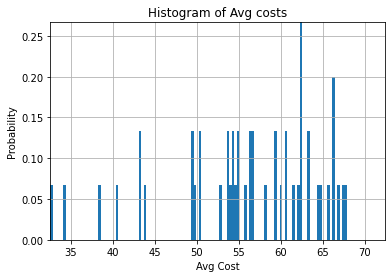

In [93]:
import numpy as np

binwidth = 0.3

n, bins, patches = plt.hist(eval_costs_scaled, bins=np.arange(min(eval_costs_scaled), max(eval_costs_scaled) + binwidth, binwidth), density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(eval_costs_scaled), np.max(eval_costs_scaled))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [94]:
np.mean(eval_costs_scaled)

56.385

In [95]:
np.std(eval_costs_scaled)

8.837829201789319

-4.666780772268401

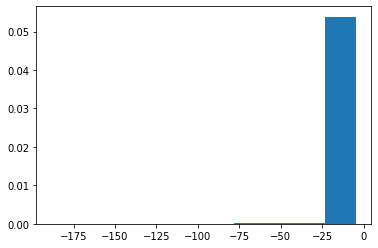

In [65]:
import numpy as np

binwidth = 0.3

state_vals = list(value_dic.values())

n, bins, patches = plt.hist(state_vals, density = True)
np.max(state_vals)

In [66]:
len(set(state_vals))

141736

In [67]:
len(state_vals)

142783

In [96]:
state_vals

[-10.883304415190103,
 -14.768922524196425,
 -9.08182990046912,
 -14.923072074539323,
 -9.302824470968423,
 -14.983319324442082,
 -24.666666666666668,
 -4.904460993813613,
 -16.703609607743665,
 -8.73588579087344,
 -19.145714026527642,
 -5.296997507648255,
 -9.795608334047055,
 -10.367992812865449,
 -14.23103378999522,
 -16.847304550553975,
 -10.972723666802638,
 -15.902378291158048,
 -7.624001382801717,
 -18.914437676707376,
 -14.689872729419978,
 -11.891124492795788,
 -16.265355745782138,
 -12.378863788510397,
 -4.691220298719193,
 -18.327922443876112,
 -6.947023735381752,
 -16.256719245746933,
 -11.195520461231283,
 -7.835756303792159,
 -17.423677561662284,
 -6.234649840910373,
 -15.79037673936662,
 -17.917869511320035,
 -7.742207329912025,
 -10.813341952960732,
 -6.745816800383439,
 -13.79843555417807,
 -12.037405080990704,
 -11.675261254206468,
 -11.276108697858493,
 -16.987263248600048,
 -11.228805361568835,
 -15.395203928445994,
 -11.093327437657653,
 -18.00928570803246,
 -6.955